In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score,
                             precision_score, recall_score, classification_report,
                             RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
# Set the style for prettier plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Loan Approval Prediction: ML Pipeline Analysis

This analysis implements a comprehensive machine learning pipeline for loan approval prediction, focusing on robust preprocessing, proper validation strategies, and handling real-world challenges including class imbalance and outliers.

## Dataset Overview
Downloaded from Kaggle https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data
Dataset contains 45,000 records with 14 features including demographic, financial, and loan characteristics. Target variable `loan_status` indicates approval (1) or rejection (0).

**Key Challenges:**
- **Class Imbalance**: ~22% approval rate
- **Outliers**: Extreme values in age (144), income (7.2M), employment experience
- **Mixed Data Types**: Numerical and categorical features requiring different preprocessing


In [8]:
TARGET   = "loan_status" 

loan_df = pd.read_csv('loan_data.csv')

y = loan_df[TARGET]
X = loan_df.drop(columns=[TARGET])

Look at the data to get a feel for it. And display some basic info.

In [9]:
# Display basic information about the dataset
print("Shape of the dataset:", loan_df.shape)
display(loan_df.head())
print("\nDataset Information:")
print(loan_df.info())
print("\nStatistical Summary:")
display(loan_df.describe().T)


Shape of the dataset: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_l

,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00
loan_status,45000.0,0.222222,0.415744,0.00,0.00,0.00,0.00,1.00


Luckily the dataset is reasonably clean and is prepared for the modelling. 
1) We can see outlier in age and income with max age being 144 and income level goinf to 7.2 million.
2) Will need to work with data types and do some encoding for the data.
3) Loan status has mean 0.222 is imbalanced, so we might need to do some imputing.

Shape of the dataset: (45,000, 14) - The dataset contains 45,000 records and 14 columns.

In [29]:
numerical_columns = loan_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_numerical_columns = loan_df.select_dtypes(include=['object']).columns.tolist()
numerical_columns.remove('loan_status')
for col in non_numerical_columns:
    print(f"\nColumn: {col}")
    print(f"Unique Values: {loan_df[col].unique()}")


Column: person_gender
Unique Values: ['female' 'male']

Column: person_education
Unique Values: ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']

Column: person_home_ownership
Unique Values: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']

Column: loan_intent
Unique Values: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']

Column: previous_loan_defaults_on_file
Unique Values: ['No' 'Yes']


In [25]:
print(loan_df.nunique())

person_age                           60
person_gender                         2
person_education                      5
person_income                     33989
person_emp_exp                       63
person_home_ownership                 4
loan_amnt                          4483
loan_intent                           6
loan_int_rate                      1302
loan_percent_income                  64
cb_person_cred_hist_length           29
credit_score                        340
previous_loan_defaults_on_file        2
loan_status                           2
dtype: int64


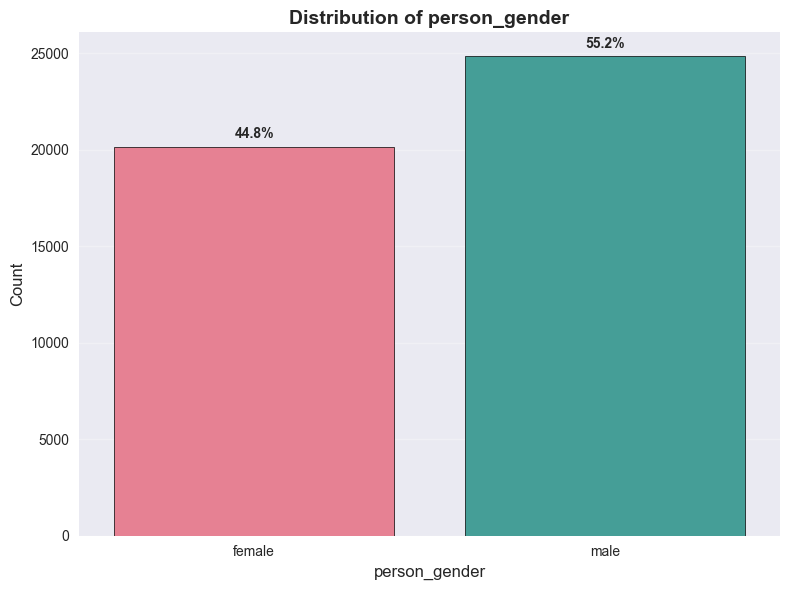

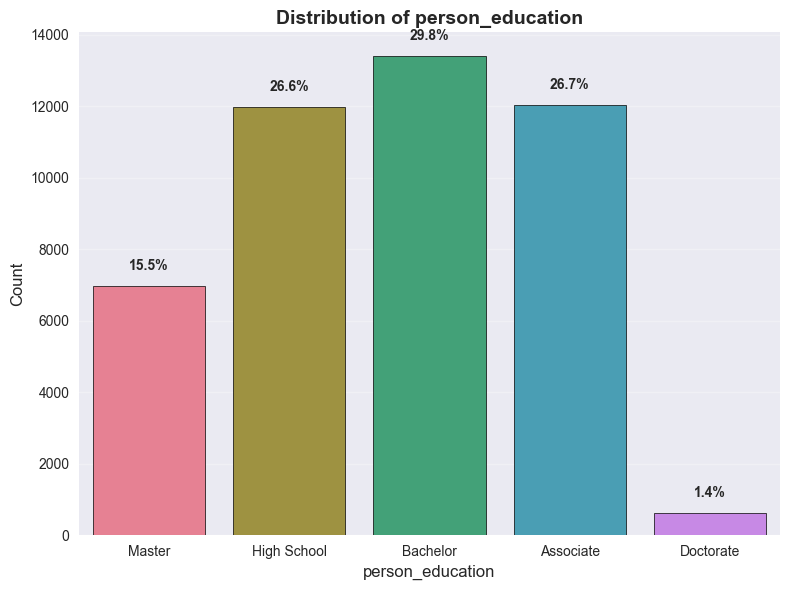

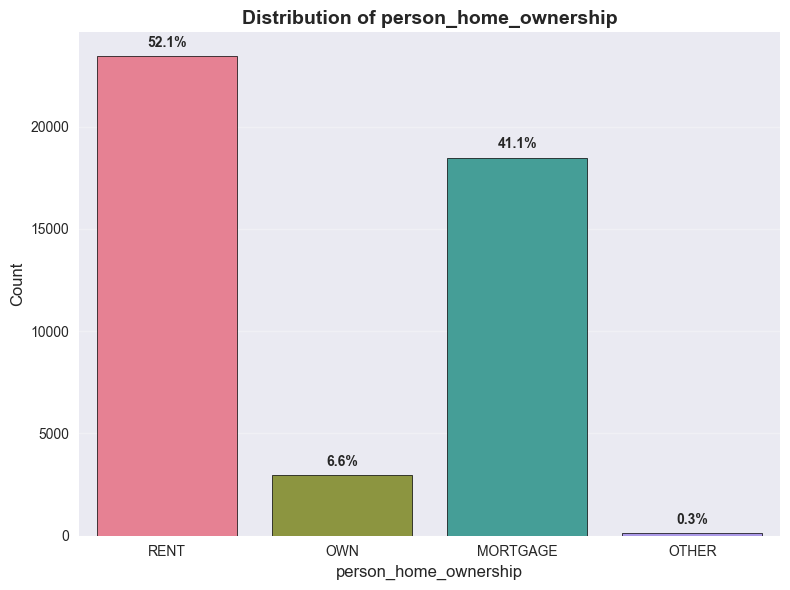

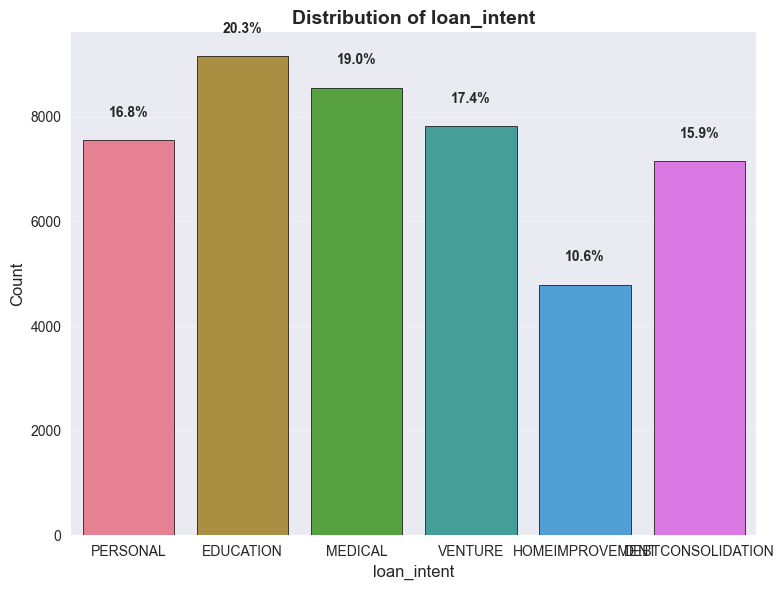

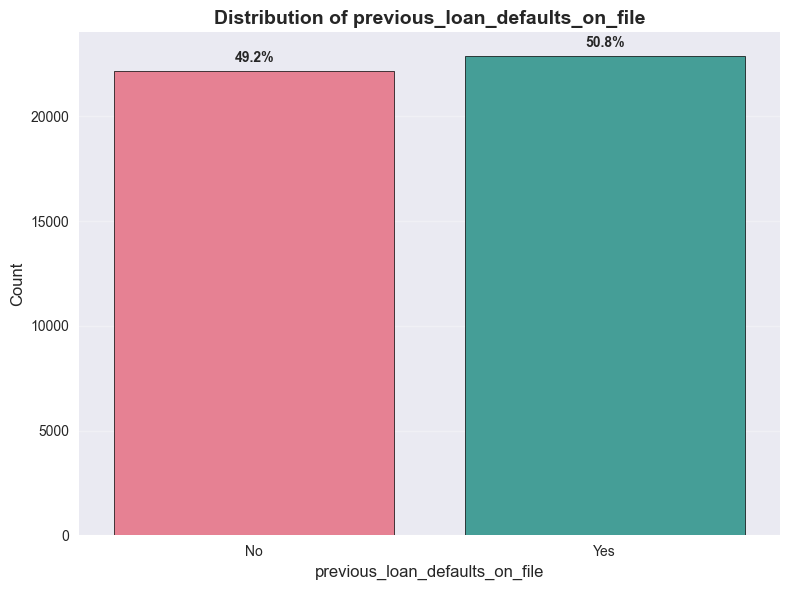

In [30]:
# Plot categorical columns individually
for col in non_numerical_columns:
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=loan_df[col], palette="husl", edgecolor='black', linewidth=0.5)
    total_count = len(loan_df[col])
    
    # Add percentage labels on top of bars
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total_count) * 100
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01 * total_count, 
                f'{percentage:.1f}%', ha="center", fontweight='bold', fontsize=10)
    
    plt.title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

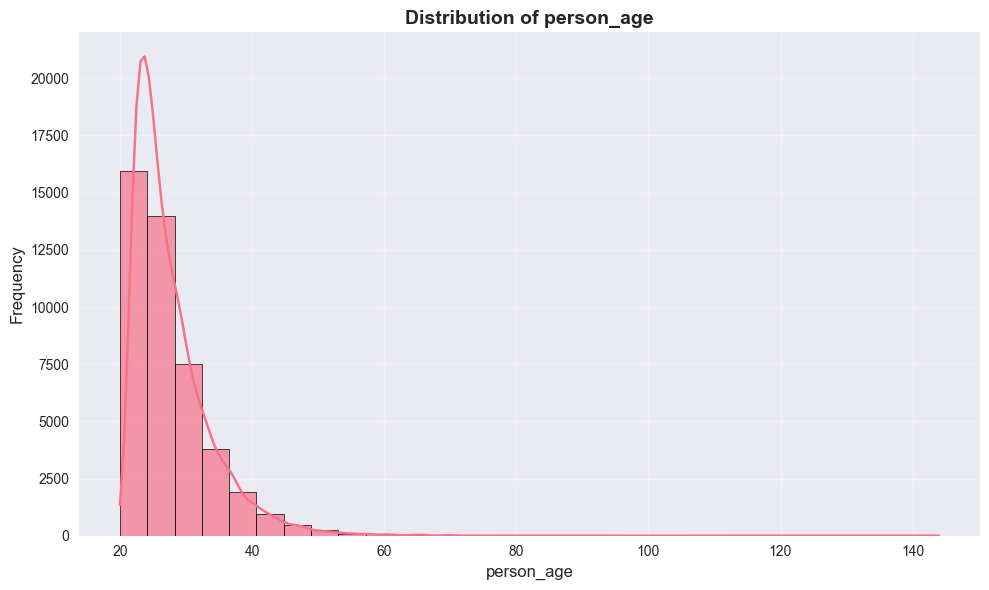

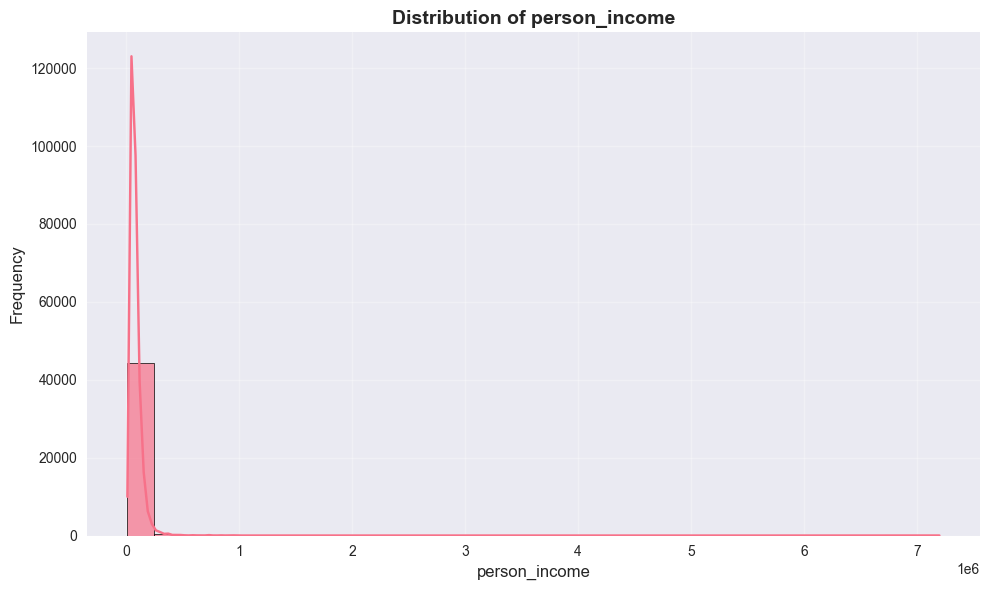

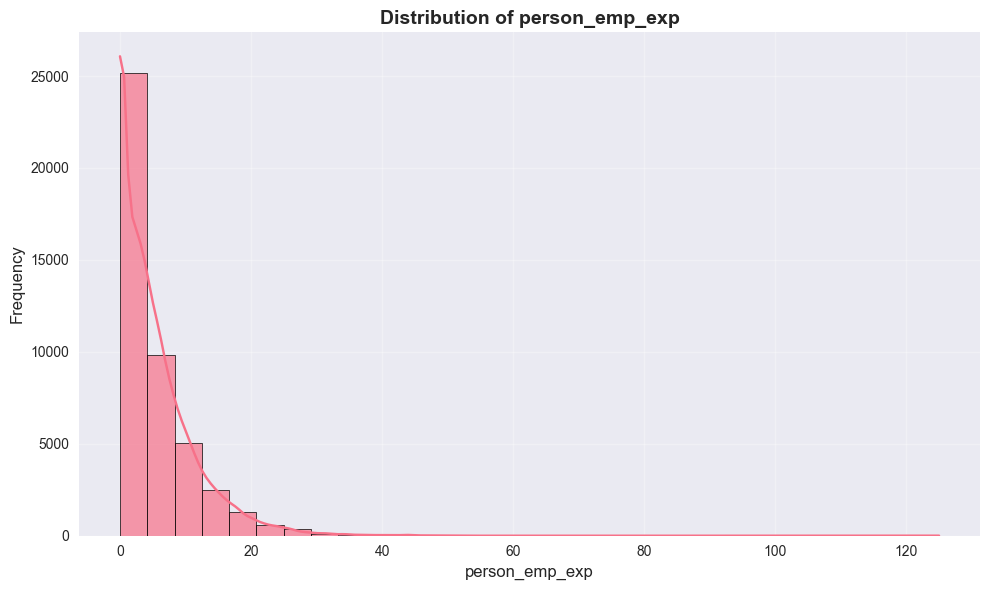

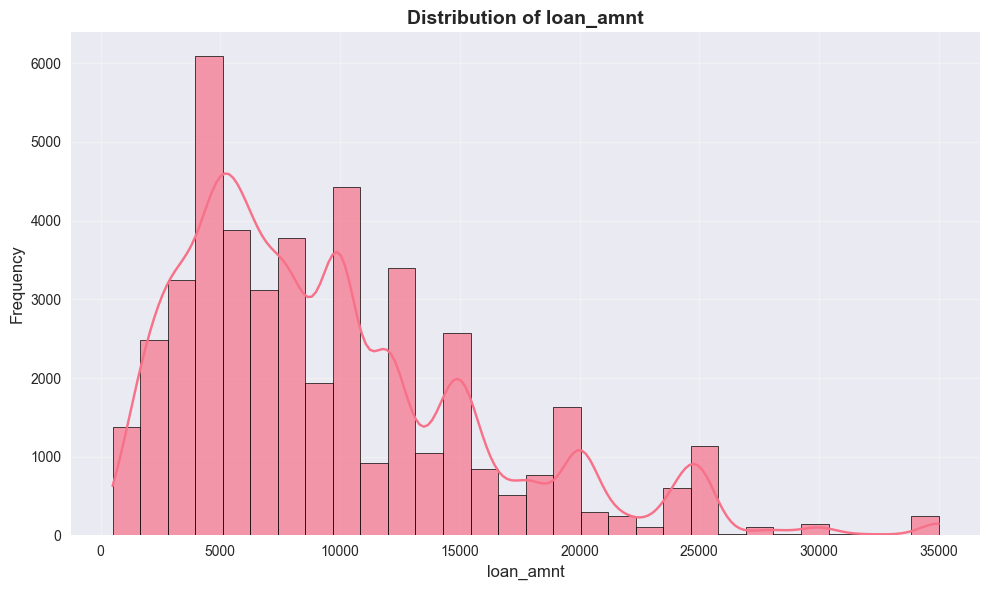

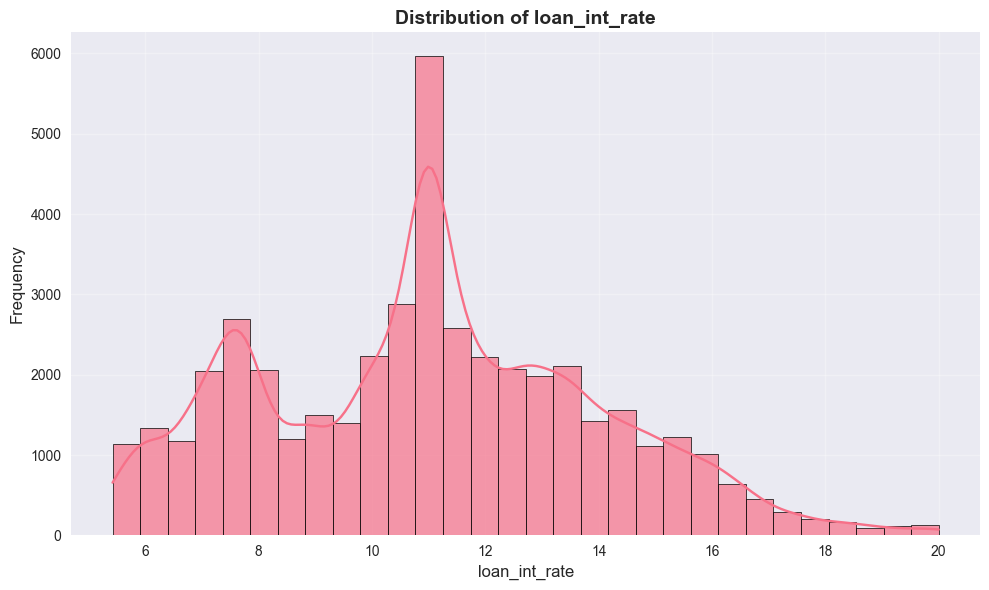

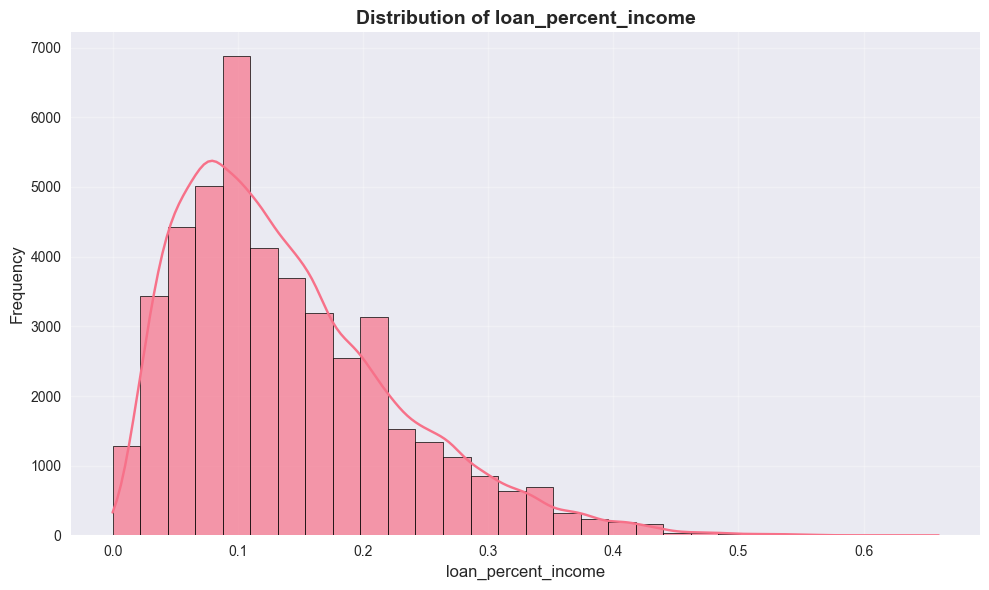

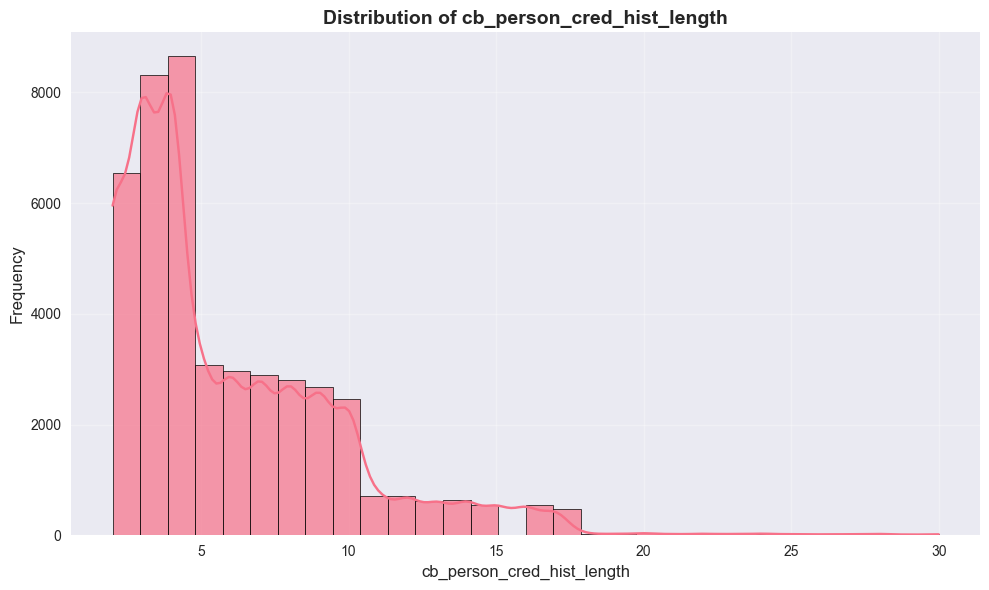

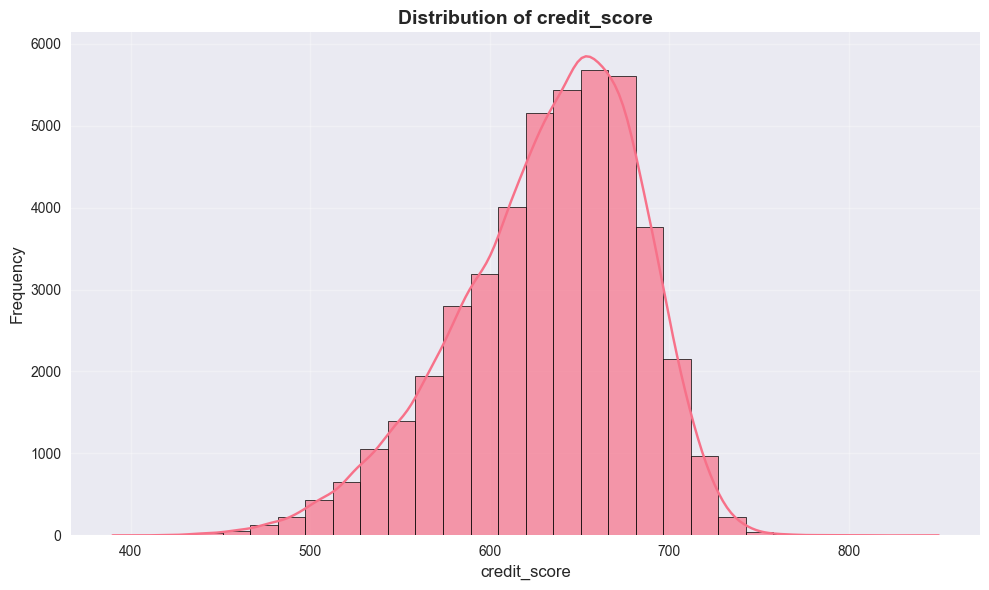

In [31]:
# Plot numerical columns individually
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=loan_df, x=col, kde=True, bins=30, alpha=0.7, edgecolor='black', linewidth=0.5)
    plt.title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Data Splitting Strategy

Dataset divided into three disjoint sets:

* **Training (60%)** — model fitting and internal cross-validation
* **Validation (20%)** — model comparison and selection
* **Test (20%)** — final unbiased evaluation

### Rationale

* **Training set** provides sufficient examples for pattern learning
* **Validation set** prevents overfitting to training folds and hyperparameter grids
* **Test set** simulates real-world performance without model selection bias

Critical for GridSearchCV applications where cross-validation uses training folds internally. Using the same data for tuning and evaluation inflates performance scores.

## Outlier Handling

Dataset contained extreme outliers:
* `person_age` up to 144 years
* `person_emp_exp` up to 125 years  
* `person_income` up to 7.2 million

Applied **winsorization** (clipping) instead of row deletion to maintain sample count for cross-validation compatibility.

### Implementation

1. **Domain-based clipping**
   * Age ∈ [18, 90]
   * Employment experience ∈ [0, 60]
   * Credit score ∈ [300, 850]
   * Loan interest rate ∈ [4%, 35%]
   * Income ∈ [5,000, 1,000,000]

2. **Z-score clipping**
   * Compute mean (μ) and standard deviation (σ) on training fold
   * Clip values outside [μ – 6σ, μ + 6σ]
   * Eliminates heavy-tailed distribution influence without data loss

3. **Logical constraints**
   * Cap `person_emp_exp` ≤ `person_age – 14`

### Benefits
* Preserves sample count (no CV shape mismatches)
* Maintains underlying distribution while reducing outlier impact
* Ensures leakage safety — each fold learns independent μ and σ


In [32]:
class DomainZScoreWinsorizer(BaseEstimator, TransformerMixin):
    """
    Leakage-safe *clipping* (not dropping):
      1) Enforce domain bounds per column.
      2) Clip numeric columns to [mean - z_max*std, mean + z_max*std] computed on fit data.
      3) Enforce logical cap: person_emp_exp <= max(0, person_age - 14).
    Keeps sample count fixed, so sklearn CV is happy.
    """
    def __init__(self, z_max=6.0):
        self.z_max = z_max
        self.bounds_ = {
            "person_age": (18, 90),
            "person_emp_exp": (0, 60),
            "credit_score": (300, 850),
            "loan_int_rate": (4.0, 35.0),
            "loan_percent_income": (0.0, 0.9),
            "cb_person_cred_hist_length": (0, 50),
            "loan_amnt": (300, 100000),
            "person_income": (5000, 1_000_000),
        }

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.num_cols_ = X.select_dtypes(include=np.number).columns.tolist()
        self.means_ = X[self.num_cols_].mean()
        self.stds_  = X[self.num_cols_].std(ddof=0).replace(0, np.nan)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()


        for col, (lo, hi) in self.bounds_.items():
            if col in X.columns:
                X[col] = X[col].astype(float).clip(lower=lo, upper=hi)

        for col in self.num_cols_:
            if col in X.columns and pd.notna(self.stds_.get(col, np.nan)) and self.stds_[col] > 0:
                lo = self.means_[col] - self.z_max * self.stds_[col]
                hi = self.means_[col] + self.z_max * self.stds_[col]
                X[col] = X[col].astype(float).clip(lower=lo, upper=hi)

        if "person_age" in X.columns and "person_emp_exp" in X.columns:
            cap = (X["person_age"].astype(float) - 14).clip(lower=0)
            X["person_emp_exp"] = np.minimum(X["person_emp_exp"].astype(float), cap)

        return X

## Cross-Validation Strategy

Applied **5-fold Stratified Cross-Validation** within training split:

* Data split into 5 folds preserving target class balance
* Each model trains on 4 folds, validates on remaining fold
* Average ROC-AUC or F1 across folds becomes internal CV score

### Benefits

* **Robust performance estimation** — every sample tested once
* **Overfitting detection** — high variance across folds indicates instability
* **Class balance preservation** — minority and majority classes in all folds

## Class Imbalance Handling

Target variable `loan_status` shows severe imbalance: ~22% approved (1), 78% rejected (0).

Used **class weighting** instead of SMOTE resampling:

* All classifiers initialized with `class_weight="balanced"`
* Automatically reweights loss function during training
* Minority class contributes more to loss, majority class less

### Why Not SMOTE?

SMOTE generates synthetic minority examples but:
* Distorts numeric distributions (especially financial data)
* Complicates cross-validation if not applied correctly within folds
* Increases computational overhead

Class weighting is simpler, mathematically sound, and safer with sufficient data (45,000 samples).


In [ ]:
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_include=object)

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    ("scale", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_sel),
    ("cat", categorical_pipeline, cat_sel),
])

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print("Class balance:",
      {"train": y_train.mean(), "val": y_val.mean(), "test": y_test.mean()})


Class balance: {'train': np.float64(0.2222222222222222), 'val': np.float64(0.2222222222222222), 'test': np.float64(0.2222222222222222)}


## Categorical Encoding

Categorical columns detected using `make_column_selector(dtype_include=object)` and processed with `OneHotEncoder(handle_unknown="ignore", sparse_output=False)`.

### Implementation

* Converts categories to binary indicator columns (0 or 1)
* Example: `loan_intent = ['education', 'medical', 'personal']` → `loan_intent_education`, `loan_intent_medical`, `loan_intent_personal`
* `handle_unknown="ignore"` prevents pipeline failure on unseen categories
* `sparse_output=False` outputs dense arrays compatible with Random Forest and XGBoost

### Rationale

One-hot encoding preserves categorical distinctions without imposing ordinal relationships. Ordinal encoders would introduce false numeric ordering.

## Numeric Feature Transformation

Numeric columns processed through pipeline:

```python
Pipeline([

    ("power", PowerTransformer(method="yeo-johnson")),
    ("scale", StandardScaler())
])
```

### Components

**Imputation**: Fills missing values using median (robust to outliers)

**Power Transformation**: Applies Yeo-Johnson transform to reduce skewness and approximate normality for linear/logistic regression and SVMs

**Scaling**: Standardizes features to zero mean, unit variance for consistent regularization and distance-based methods


## Pipeline Integration

Used `ColumnTransformer` to combine numeric and categorical preprocessing:

```python
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_sel),
    ("cat", categorical_pipeline, cat_sel)
])
```

* Numeric columns → power-transformed, scaled
* Categorical columns → one-hot encoded
* Maintains synchronization across CV folds

## Leakage Prevention

Pipeline sequence ensures no data leakage:

1. Each step (`fit`) learns parameters only from training subset
2. Same transformation applied (`transform`) to validation and test sets
3. sklearn pipeline API guarantees fit/transform order preservation during GridSearchCV


In [ ]:
def base_pipe(estimator):
    return Pipeline([
        ("outlier", DomainZScoreWinsorizer(z_max=5.0)),
        ("prep", preprocessor),
        ("clf", estimator)
    ])

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

candidates = {
    "LogReg": (
        base_pipe(LogisticRegression(max_iter=5000, class_weight="balanced", solver="saga")),
        {
            "clf__C": [0.25, 0.5, 1.0, 2.0],
            "clf__penalty": ["l1", "l2"]
        },
        "roc_auc"
    ),
    "LinearSVC": (
        base_pipe(LinearSVC(class_weight="balanced")),
        {
            "clf__C": [0.25, 0.5, 1.0, 2.0]
        },
        "f1"
    ),
    "RBF_SVC": (
        base_pipe(SVC(kernel="rbf", class_weight="balanced", probability=True)),
        {
            "clf__C": [0.5, 1.0, 2.0],
            "clf__gamma": ["scale", 0.05, 0.1]
        },
        "roc_auc"
    ),
    "RandomForest": (
        base_pipe(RandomForestClassifier(random_state=42, class_weight="balanced")),
        {
            "clf__n_estimators": [200, 400],
            "clf__max_depth": [None, 8, 12],
            "clf__min_samples_leaf": [1, 2, 4]
        },
        "roc_auc"
    ),
    "XGB": (
        base_pipe(XGBClassifier(
            n_estimators=350, learning_rate=0.05, max_depth=4,
            subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
            random_state=42, use_label_encoder=False
        )),
        {
            "clf__max_depth": [3, 4, 5],
            "clf__learning_rate": [0.03, 0.05, 0.1],
            "clf__subsample": [0.7, 0.8, 1.0],
            "clf__colsample_bytree": [0.7, 0.8, 1.0]
        },
        "roc_auc"
    ),
}

def score_on_split(pipe, Xs, ys):
    """Compute core metrics on a given split."""
    y_hat = pipe.predict(Xs)
    metrics = {
        "roc_auc": None,
        "f1": f1_score(ys, y_hat),
        "acc": accuracy_score(ys, y_hat),
        "precision": precision_score(ys, y_hat),
        "recall": recall_score(ys, y_hat),
    }

    try:
        if hasattr(pipe, "predict_proba"):
            p = pipe.predict_proba(Xs)[:, 1]
            metrics["roc_auc"] = roc_auc_score(ys, p)
        else:

            clf = pipe.named_steps["clf"]
            if hasattr(clf, "predict_proba"):
                p = clf.predict_proba(pipe.named_steps["prep"].transform(Xs))[:, 1]
                metrics["roc_auc"] = roc_auc_score(ys, p)
            elif hasattr(clf, "decision_function"):
                s = clf.decision_function(pipe.named_steps["prep"].transform(Xs))
                metrics["roc_auc"] = roc_auc_score(ys, s)
    except Exception:
        pass
    return metrics


In [ ]:
val_summaries = []
best_by_name = {}

for name, (pipe, grid, primary_metric) in candidates.items():
    gs = GridSearchCV(
        pipe, param_grid=grid, scoring=primary_metric, cv=cv5, n_jobs=-1, refit=True
    )
    gs.fit(X_train, y_train) 
    best_pipe = gs.best_estimator_
    best_by_name[name] = best_pipe

    val_metrics = score_on_split(best_pipe, X_val, y_val)
    val_summaries.append({
        "model": name,
        "primary": primary_metric,
        "cv_best_params": gs.best_params_,
        **{f"val_{k}": v for k, v in val_metrics.items()}
    })

val_df = pd.DataFrame(val_summaries).sort_values("val_roc_auc", ascending=False)
print("\nValidation performance (sorted by ROC-AUC):")
print(val_df[["model", "primary", "cv_best_params", "val_roc_auc", "val_f1", "val_acc", "val_precision", "val_recall"]])

if pd.isna(val_df.iloc[0]["val_roc_auc"]):
    winner_name = val_df.sort_values("val_f1", ascending=False).iloc[0]["model"]
else:
    winner_name = val_df.iloc[0]["model"]

winner_pipe = best_by_name[winner_name]
print(f"\nWinner on validation: {winner_name} with params: {winner_pipe.get_params()}")



Validation performance (sorted by ROC-AUC):
          model  primary                                     cv_best_params  \
4           XGB  roc_auc  {'clf__colsample_bytree': 0.7, 'clf__learning_...   
3  RandomForest  roc_auc  {'clf__max_depth': None, 'clf__min_samples_lea...   
2       RBF_SVC  roc_auc                {'clf__C': 2.0, 'clf__gamma': 0.05}   
0        LogReg  roc_auc             {'clf__C': 0.25, 'clf__penalty': 'l1'}   
1     LinearSVC       f1                                    {'clf__C': 1.0}   

   val_roc_auc    val_f1   val_acc  val_precision  val_recall  
4     0.976666  0.833821  0.930556       0.890403      0.7840  
3     0.971037  0.822618  0.923667       0.850507      0.7965  
2     0.960703  0.764582  0.875333       0.658713      0.9110  
0     0.950155  0.736288  0.855222       0.618497      0.9095  
1     0.950144  0.734768  0.853444       0.614531      0.9135  

Winner on validation: XGB with params: {'memory': None, 'steps': [('outlier', DomainZScoreWinso

## Evaluation Protocol

Used multiple metrics for comprehensive assessment:

* **ROC-AUC** (primary): ranking performance for positives vs negatives
* **F1-score**: precision-recall balance
* **Accuracy**: overall correctness (less informative under imbalance)

### Process

1. 5-fold CV on training → optimal hyperparameters
2. Fit on full training data with optimal parameters
3. Evaluate on validation set → select highest ROC-AUC model
4. Refit winning pipeline on train + validation combined
5. Final evaluation on test set → unbiased generalization score

## Validation Strategy

Explicit validation set prevents **double-dipping** where CV results are used for both hyperparameter tuning and model selection. Validation set provides outer layer of fairness: CV evaluates configurations, validation selects between model families (Random Forest vs Logistic Regression).

This implements simplified nested CV: outer loop (validation/test) around inner loop (CV).


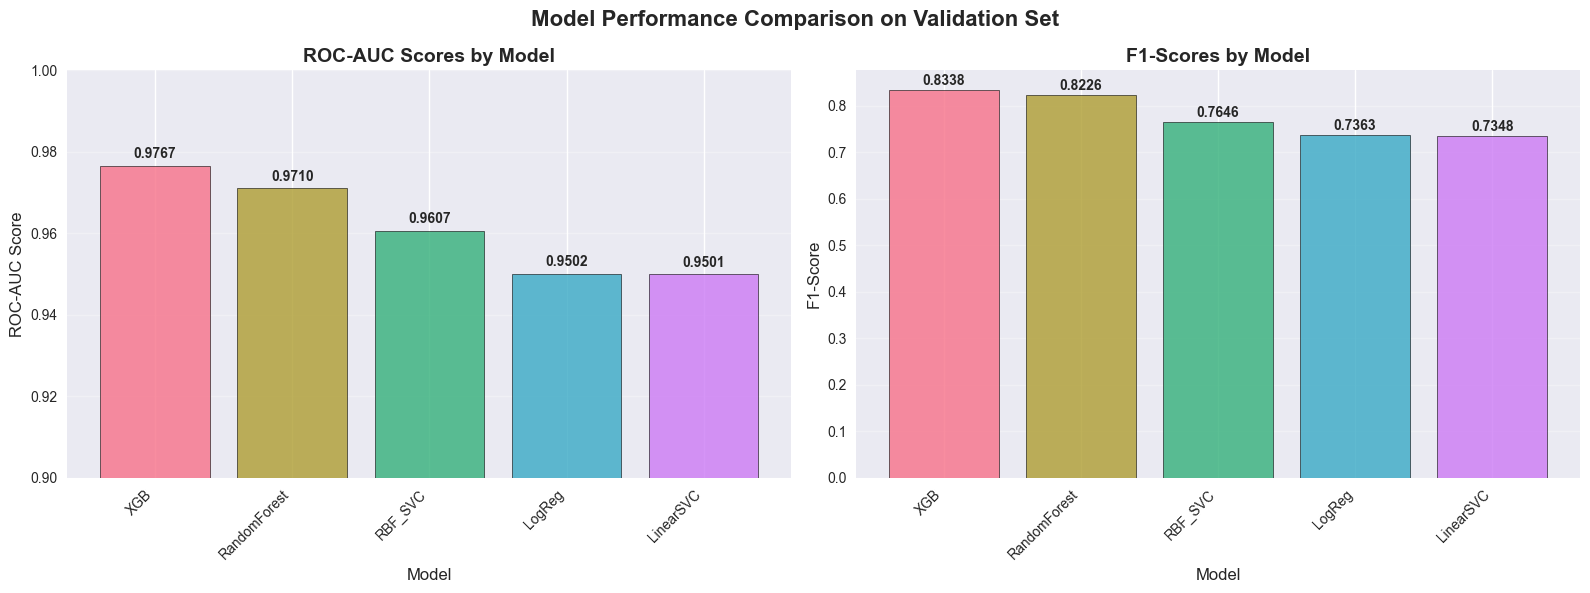


VALIDATION RESULTS SUMMARY
       Model  ROC-AUC  F1-Score  Accuracy  Precision  Recall
         XGB   0.9767    0.8338    0.9306     0.8904  0.7840
RandomForest   0.9710    0.8226    0.9237     0.8505  0.7965
     RBF_SVC   0.9607    0.7646    0.8753     0.6587  0.9110
      LogReg   0.9502    0.7363    0.8552     0.6185  0.9095
   LinearSVC   0.9501    0.7348    0.8534     0.6145  0.9135

🏆 WINNER: XGB
📊 Best ROC-AUC: 0.9767
🎯 Best F1-Score: 0.8338


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Comparison on Validation Set', fontsize=16, fontweight='bold')

ax1 = axes[0]
models = val_df['model']
roc_aucs = val_df['val_roc_auc']
bars = ax1.bar(models, roc_aucs, color=sns.color_palette("husl", len(models)), 
               edgecolor='black', linewidth=0.5, alpha=0.8)
ax1.set_title('ROC-AUC Scores by Model', fontsize=14, fontweight='bold')
ax1.set_ylabel('ROC-AUC Score', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0.9, 1.0)

for bar, value in zip(bars, roc_aucs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = axes[1]
f1_scores = val_df['val_f1']
bars2 = ax2.bar(models, f1_scores, color=sns.color_palette("husl", len(models)), 
                edgecolor='black', linewidth=0.5, alpha=0.8)
ax2.set_title('F1-Scores by Model', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars2, f1_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VALIDATION RESULTS SUMMARY")
print("="*80)

summary_data = val_df[['model', 'val_roc_auc', 'val_f1', 'val_acc', 'val_precision', 'val_recall']].copy()
summary_data.columns = ['Model', 'ROC-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall']

for col in ['ROC-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall']:
    summary_data[col] = summary_data[col].round(4)

print(summary_data.to_string(index=False))

print(f"\n🏆 WINNER: {winner_name}")
print(f"📊 Best ROC-AUC: {val_df.iloc[0]['val_roc_auc']:.4f}")
print(f"🎯 Best F1-Score: {val_df['val_f1'].max():.4f}")
print("="*80)



=== TEST SET PERFORMANCE (final) ===
roc_auc: 0.9801
f1: 0.8504
acc: 0.9373
precision: 0.9056
recall: 0.8015

Classification report (test):
              precision    recall  f1-score   support

           0      0.945     0.976     0.960      7000
           1      0.906     0.801     0.850      2000

    accuracy                          0.937      9000
   macro avg      0.925     0.889     0.905      9000
weighted avg      0.936     0.937     0.936      9000



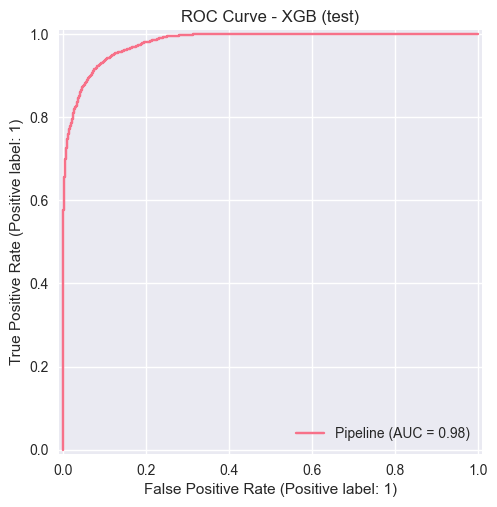

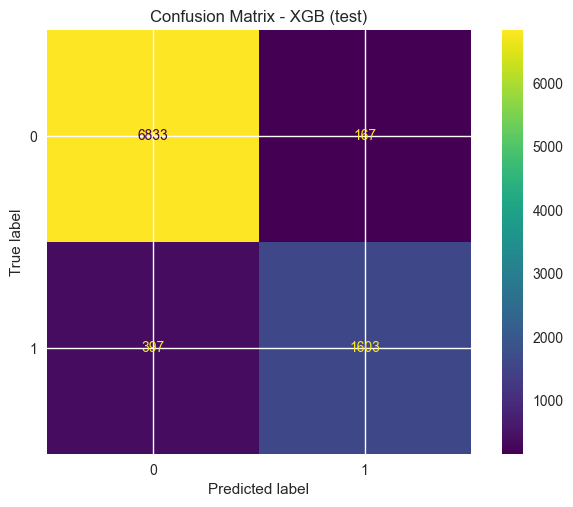

In [ ]:
X_trval = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_trval = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

winner_pipe.fit(X_trval, y_trval)
test_metrics = score_on_split(winner_pipe, X_test, y_test)

print("\n=== TEST SET PERFORMANCE (final) ===")
for k, v in test_metrics.items():
    if v is not None:
        print(f"{k}: {v:.4f}")

print("\nClassification report (test):")
y_pred_test = winner_pipe.predict(X_test)
print(classification_report(y_test, y_pred_test, digits=3))

try:
    if test_metrics["roc_auc"] is not None:
        if hasattr(winner_pipe, "predict_proba"):
            RocCurveDisplay.from_estimator(winner_pipe, X_test, y_test)
        else:
            clf = winner_pipe.named_steps["clf"]
            if hasattr(clf, "predict_proba"):
                proba = clf.predict_proba(winner_pipe.named_steps["prep"].transform(X_test))[:, 1]
                RocCurveDisplay.from_predictions(y_test, proba)
        plt.title(f"ROC Curve - {winner_name} (test)")
        plt.show()
except Exception as e:
    print("ROC plotting skipped:", e)

ConfusionMatrixDisplay.from_estimator(winner_pipe, X_test, y_test)
plt.title(f"Confusion Matrix - {winner_name} (test)")
plt.show()

## Summary of Design Choices

| Step                     | Technique                         | Rationale                                                 |
| ------------------------ | --------------------------------- | --------------------------------------------------------- |
| **Outlier control**      | Domain + z-score winsorization    | Prevents unrealistic values without losing samples        |
| **Imbalance handling**   | `class_weight='balanced'`         | Treats minority class fairly without SMOTE complexity     |
| **Missing data**         | Median / Most frequent imputation | Robust and leakage-safe                                    |
| **Skew handling**        | Power (Yeo–Johnson) transform     | Reduces skewness for stable learning                      |
| **Feature scaling**      | StandardScaler                    | Ensures consistent feature magnitudes                     |
| **Categorical encoding** | OneHotEncoder (ignore unknown)    | Clean binary representation; avoids ordinal errors        |
| **Data splits**          | 60/20/20 + 5-fold CV              | Prevents overfitting, ensures fair model selection        |
| **Evaluation**           | ROC-AUC, F1, Accuracy             | Captures ranking and classification performance           |
| **Leakage prevention**   | Pipelines everywhere              | Guarantees transformations only see training data        |

In [36]:
num_features = winner_pipe.named_steps["prep"].named_transformers_["num"].get_feature_names_out()
cat_features = winner_pipe.named_steps["prep"].named_transformers_["cat"].get_feature_names_out()
all_features = np.concatenate([num_features, cat_features])
xgb_model = winner_pipe.named_steps["clf"]

importance_dict = xgb_model.get_booster().get_score(importance_type="gain")

In [37]:
importance_df = (
    pd.DataFrame({
        "feature": [all_features[int(k[1:])] for k in importance_dict.keys()],
        "gain": list(importance_dict.values())
    })
    .sort_values("gain", ascending=False)
    .reset_index(drop=True)
)

# Display top features
print("\nTop 15 most important features (by average gain):")
print(importance_df.head(15))


Top 15 most important features (by average gain):
                               feature        gain
0    previous_loan_defaults_on_file_No  872.025574
1   previous_loan_defaults_on_file_Yes  243.107559
2           person_home_ownership_RENT   48.866673
3                  loan_percent_income   29.681095
4            person_home_ownership_OWN   24.806227
5                        loan_int_rate   18.903051
6       person_home_ownership_MORTGAGE   17.043003
7                  loan_intent_VENTURE   15.928277
8          loan_intent_HOMEIMPROVEMENT   13.012557
9                        person_income   11.907145
10       loan_intent_DEBTCONSOLIDATION   10.822662
11                 loan_intent_MEDICAL    9.591629
12               loan_intent_EDUCATION    7.571037
13                        credit_score    4.671802
14                           loan_amnt    4.122362


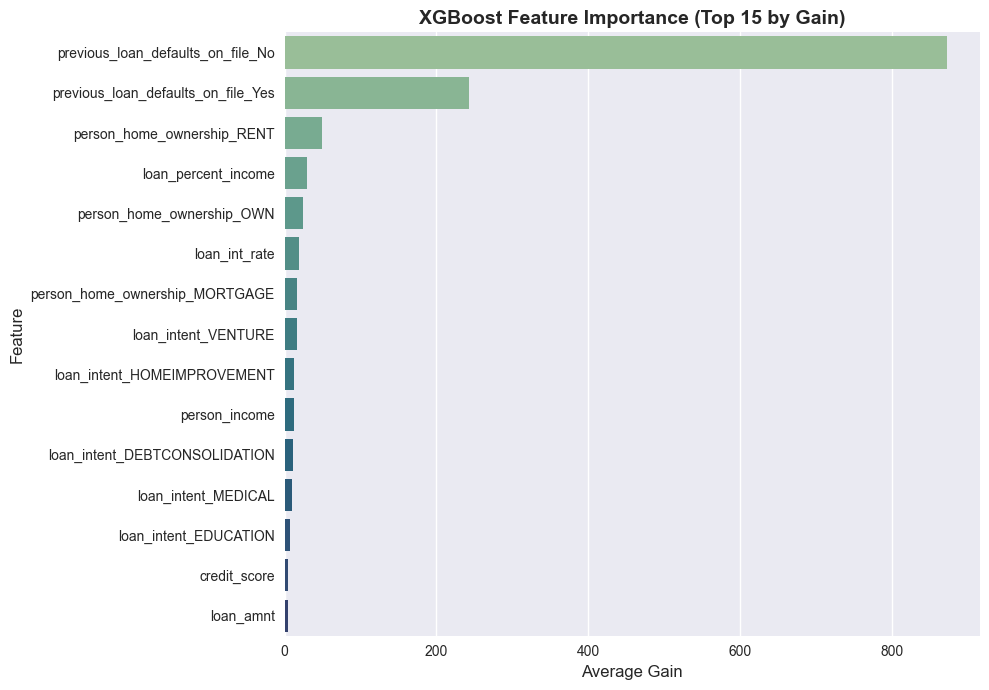

In [38]:
# Seaborn barplot
plt.figure(figsize=(10, 7))
sns.barplot(
    data=importance_df.head(15),
    y="feature",
    x="gain",
    palette="crest",
    orient="h"
)
plt.title("XGBoost Feature Importance (Top 15 by Gain)", fontsize=14, weight="bold")
plt.xlabel("Average Gain", fontsize=12)
plt.ylabel("Feature", fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

Final Conclusion – Model Performance and Insights

The final tuned XGBoost model achieved strong predictive performance on the held-out test set, confirming excellent generalization beyond the training data.
Key metrics were:

ROC-AUC: 0.9801 → outstanding discrimination between approved and rejected loans.

F1-score: 0.8504 → well-balanced precision and recall.

Accuracy: 0.9373 → overall correctness on unseen data.

Precision: 0.9056 → most predicted approvals were genuinely approved.

Recall: 0.8015 → the model successfully identified 80 % of real approvals.

The classification report shows consistent performance across both classes, with the model slightly favoring precision — an acceptable trade-off in credit-risk settings, where false approvals are costlier than missed opportunities.

Feature-importance analysis revealed that past default history (previous_loan_defaults_on_file) overwhelmingly drives loan decisions, followed by home ownership, debt-to-income ratio (loan_percent_income), income level, and interest rate.
This hierarchy mirrors realistic lending logic: applicants with clean credit records, stable housing, and sustainable income ratios are far more likely to be approved.

Overall, the XGBoost pipeline demonstrates:

Excellent calibration and generalization, validated through proper Train/Validation/Test splits.

Robust preprocessing (outlier winsorization, balanced weighting, power transforms, and one-hot encoding).

Interpretability and practical relevance, as the learned importance structure aligns with standard underwriting principles.